In [1]:
import torch
import intel_extension_for_pytorch as ipex

C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [174]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration

processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small").to("xpu")

C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\transformers\models\encodec\modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


In [238]:
inputs = processor(
    text=["Dramatic 90s piano music"],
    padding=True,
    return_tensors="pt",
)
inputs = {k:v.to('xpu') for k,v in inputs.items()}

with torch.no_grad():
    torch.manual_seed(54)
    audio_values = model.generate(**inputs, max_new_tokens=256).cpu()

In [239]:

#help(model.generate)
base_audio_values=audio_values

In [240]:
from IPython.display import Audio

sampling_rate = model.config.audio_encoder.sampling_rate
Audio(audio_values[0].numpy(), rate=sampling_rate,)

In [241]:
audio_values.shape

torch.Size([1, 1, 161920])

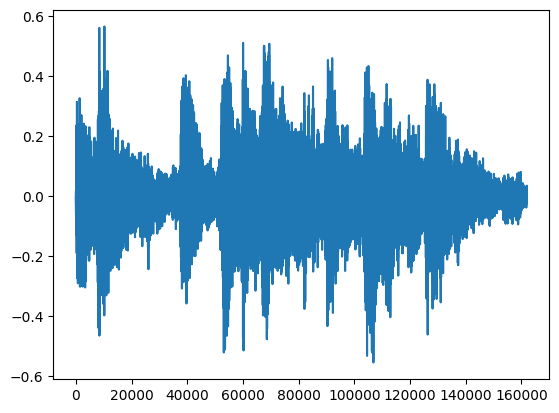

In [242]:
import matplotlib.pyplot as plt

plt.plot(base_audio_values[0][0])

In [246]:
inputs = processor(
    audio=base_audio_values[0][0],
    text=["Drums coming in"],#["80s Rock gitar"],
    padding=True,
    return_tensors="pt",
)
inputs = {k:v.to('xpu') for k,v in inputs.items()}

with torch.no_grad():
    torch.manual_seed(31)
    audio_values = model.generate(**inputs, max_new_tokens=256).cpu()

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [247]:
Audio(audio_values[0].numpy(), rate=sampling_rate)

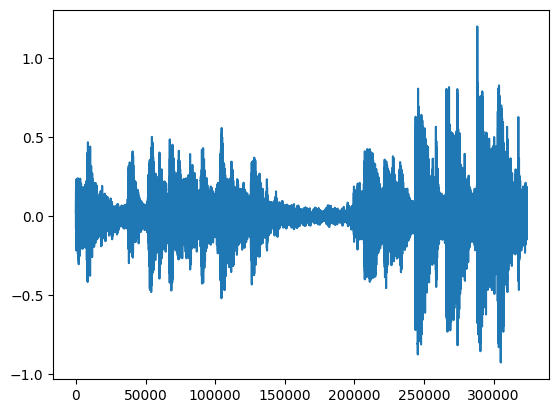

In [248]:
import matplotlib.pyplot as plt

plt.plot(audio_values[0][0])

In [103]:
# import scipy

# sampling_rate = model.config.audio_encoder.sampling_rate
# scipy.io.wavfile.write("musicgen_out.wav", rate=sampling_rate, data=audio_values[0, 0].numpy())

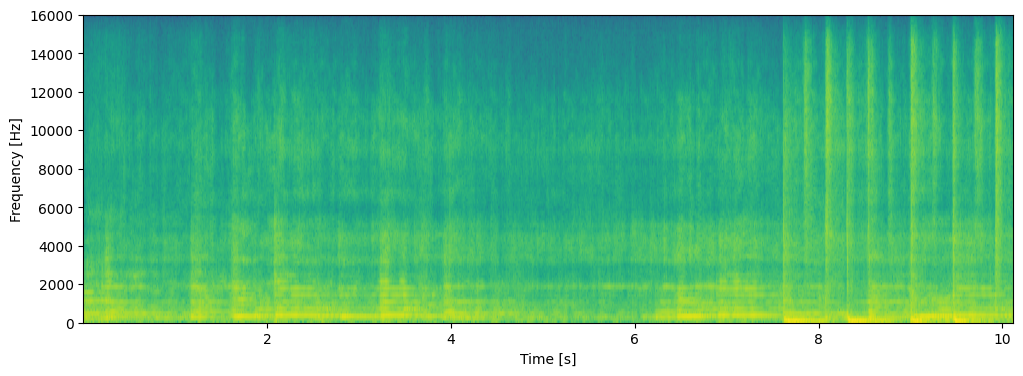

In [261]:
def plot_spectogram( sound ):
    fig, ax3 = plt.subplots(1, 1, figsize=(12, 4))
    ax3.specgram(sound, Fs=sampling_rate)
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('Frequency [Hz]')

plot_spectogram(audio_values[0][0])

# lookig on the internals

we will now look at the 3 fundemental models that make this work.

1. a text encoder model that takes text and outputs  embeddings
2. an audio encoding model that translates between audio and its own tokens
3. a new token predictor for these audio tokens that can use model 1s embedding as conditionals


the pipeline goes as follows:

1. encode the user prompt into embeddings
2. encode any past musical context into tokens
3. use the decoder to predict the next tokens
4. decode the tokens back into sound

In [262]:
#we will now look at all the parts of the model

#text -> embeddings
text=set(model.text_encoder.modules())
proj=set(model.enc_to_dec_proj.modules()) 

#audio -> tokens OR tokens -> audio
audio_enc=set(model.audio_encoder.modules())

#text_embeddings + audio_tokens -> next_audion_tokens
audio_dec=set(model.decoder.modules())

all_layers = text.union(audio_enc).union(audio_dec).union(proj)

In [263]:
model.text_encoder

T5EncoderModel(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dropout(p=0.1, 

In [264]:
[type(x) for x in model.modules() if x not in all_layers]

[transformers.models.musicgen.modeling_musicgen.MusicgenForConditionalGeneration]

In [265]:
proj

{Linear(in_features=768, out_features=1024, bias=True)}

#### text to embedding

In [266]:

text_inputs = processor.tokenizer(["Drums coming in"],return_tensors='pt')
text_inputs = {k:v.xpu() for k,v in text_inputs.items()}
with torch.no_grad():
    text_emb=model.text_encoder(**text_inputs)
text_emb

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[-1.8343e-01, -1.6788e-01, -1.3638e-01,  ...,  7.4312e-02,
          -5.7504e-01, -3.2075e-01],
         [-5.2078e-01,  1.2646e-01, -1.2453e-01,  ...,  2.9757e-01,
           4.8505e-02, -2.4622e-01],
         [-6.2492e-01,  1.0176e-01, -9.7727e-02,  ...,  1.6174e-01,
          -2.8732e-02, -4.1226e-02],
         [-3.7238e-01, -1.1041e-01,  2.1421e-01,  ..., -2.7740e-02,
          -3.6800e-01, -5.7025e-02],
         [-7.5804e-03, -3.5105e-04,  8.4690e-03,  ..., -1.6502e-03,
          -2.4512e-03,  1.8491e-03]]], device='xpu:0'), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [267]:
text_emb.keys()

odict_keys(['last_hidden_state'])

In [268]:
with torch.no_grad():
    text_emb = model.enc_to_dec_proj(text_emb.last_hidden_state)
text_emb.shape

torch.Size([1, 5, 1024])

#### audio to tokens

In [269]:
with torch.no_grad():
    encoded=model.audio_encoder(input_values=audio_values.xpu())

In [270]:
encoded.audio_codes

tensor([[[[1001, 1453,  178,  ...,  937,  731, 1888],
          [1592, 1592, 1592,  ..., 1387,  753,  276],
          [ 138,  138,  138,  ..., 1774, 1651, 1338],
          [1382, 1924,  208,  ..., 1745,   92,  822]]]], device='xpu:0')

In [271]:
encoded.keys()

odict_keys(['audio_codes', 'audio_values'])

In [272]:
encoded.audio_codes.shape,text_emb.shape

(torch.Size([1, 1, 4, 506]), torch.Size([1, 5, 1024]))

#### embeddings + tokens to next tokens

In [273]:
with torch.no_grad():
    ans=model.decoder(encoded.audio_codes,encoder_hidden_states=text_emb)

In [274]:
ans.keys() 

odict_keys(['logits', 'past_key_values'])

In [275]:
#note that the answer acts just like any other generative transformer. we have logits and past key values
ans.logits.shape

torch.Size([4, 506, 2048])

In [276]:
model.decoder

MusicgenForCausalLM(
  (model): MusicgenModel(
    (decoder): MusicgenDecoder(
      (embed_tokens): ModuleList(
        (0-3): 4 x Embedding(2049, 1024)
      )
      (embed_positions): MusicgenSinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-23): 24 x MusicgenDecoderLayer(
          (self_attn): MusicgenAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
          )
          (activation_fn): GELUActivation()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder_attn): MusicgenAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)


# playing with codes

to demonstrate how the music tokens are translated to audio we will try and modify them directly

In [277]:
codes=encoded.audio_codes.clone()
codes.shape

torch.Size([1, 1, 4, 506])

In [278]:
type(model.audio_encoder)

transformers.models.encodec.modeling_encodec.EncodecModel

In [279]:
model.decoder.config.audio_channels

1

In [280]:
with torch.no_grad():
    ans=model.audio_encoder.decode(codes,audio_scales=[None])
ans

EncodecDecoderOutput(audio_values=tensor([[[-0.0212, -0.0297, -0.0258,  ..., -0.0192, -0.0222, -0.0141]]],
       device='xpu:0'))

In [281]:
ans.audio_values.shape

torch.Size([1, 1, 323840])

In [282]:
#here we will just see the original audio
Audio(ans.audio_values[0].cpu().numpy(), rate=sampling_rate)

In [283]:
#lets automate this
@torch.no_grad
def codes_to_audio(codes):
    ans=model.audio_encoder.decode(codes,audio_scales=[None])
    return ans.audio_values[0][0].cpu().numpy()

In [284]:
Audio(codes_to_audio(codes[:,:,:,300:500]), rate=sampling_rate)

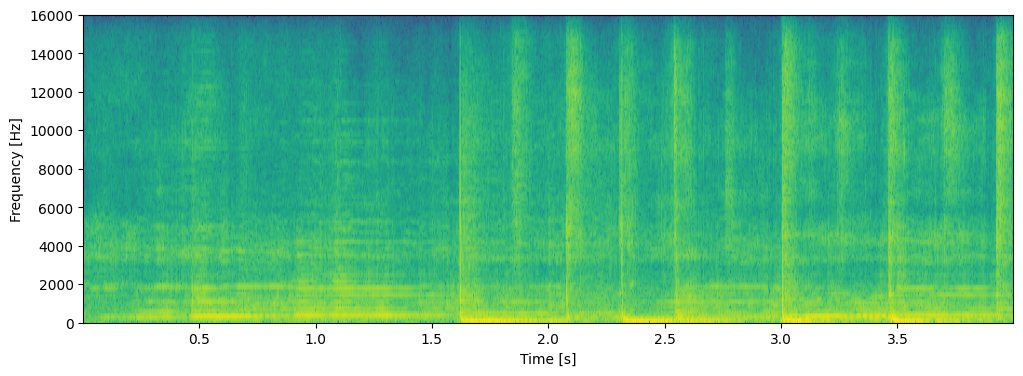

In [285]:
plot_spectogram(codes_to_audio(codes[:,:,:,300:500]))

In [126]:
#changing a few things barely matters
codes[0,0,0,300]=23
Audio(codes_to_audio(codes[:,:,:,300:500]), rate=sampling_rate)

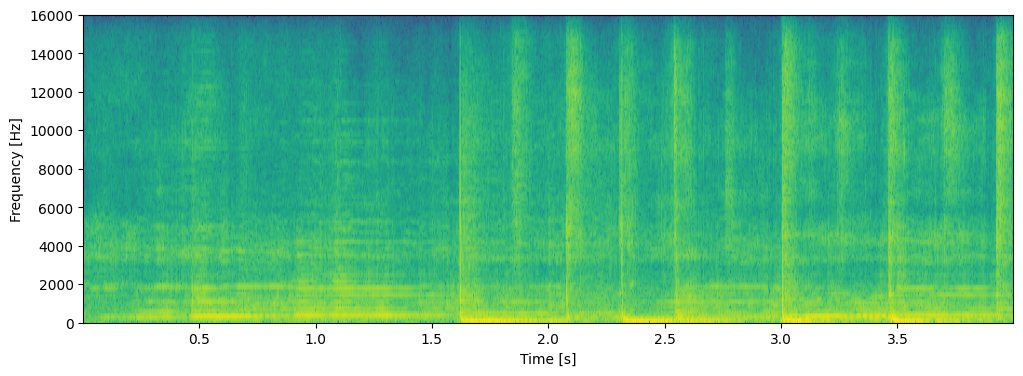

In [286]:
plot_spectogram(codes_to_audio(codes[:,:,:,300:500]))

In [287]:
codes[0,0,0,300:320]=23
Audio(codes_to_audio(codes[:,:,:,300:500]), rate=sampling_rate)

In [289]:
# plot_spectogram(codes_to_audio(codes[:,:,:,300:500]))

In [290]:
#now we take more of it
codes[0,0,0,300:400]=23
Audio(codes_to_audio(codes[:,:,:,300:500]), rate=sampling_rate)

In [292]:
#now we took over more chanels it will break
codes[0,0,2,300:400]=23
Audio(codes_to_audio(codes[:,:,:,300:500]), rate=sampling_rate)

In [ ]:
plot_spectogram(codes_to_audio(codes[:,:,:,300:500]))

In [293]:
#start will still sound fine
Audio(codes_to_audio(codes), rate=sampling_rate)

In [132]:
#looking at the effects of chanels
codes=encoded.audio_codes.clone()
codes[0,0,2,300:400]=23
Audio(codes_to_audio(codes[:,:,:,300:500]), rate=sampling_rate)

In [37]:
#looking at the effects of chanels
codes=encoded.audio_codes.clone()
codes[0,0,1,300:400]=23
Audio(codes_to_audio(codes[:,:,:,300:500]), rate=sampling_rate)

In [38]:
#looking at the effects of chanels
codes=encoded.audio_codes.clone()
codes[0,0,3,300:400]=23
Audio(codes_to_audio(codes[:,:,:,300:500]), rate=sampling_rate)